In [1]:
import torch
import numpy as np
from torchvision.transforms import transforms as T
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
sys.path.append('../dataset_loader')
sys.path.append('../model')
from config import *

In [2]:
from dataset_loader.image_loader import *
from model.resunet import *
from utils import *

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
ae = True
vae = False
test = True

In [5]:
if ae:
    model = nn.DataParallel(c_resunetAE(arch='c-ResUnetAE', n_features_start = 16, n_out = 3,
            pretrained = False, progress= True)).to(device)
    model.load_state_dict(torch.load('../model_results_torch/c-resuntAE.h5'))
elif vae:
    model = nn.DataParallel(c_resunetVAE(arch='c-ResUnetVAE', n_features_start = 16, n_out = 1,
            pretrained = False, progress= True)).to(device)
    model.load_state_dict(torch.load('../model_results_torch/cvae.h5'))
if test:
    model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16, n_out = 1,
            pretrained = False, progress= True)).to(device)
    model.load_state_dict(torch.load('../model_results_torch/c-resunt_v4.h5'))

Initializing conv2d weights with Kaiming He normal


In [6]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [7]:
transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                       T.ToTensor(),
                       #T.Resize((1040,1400))
                      #T.Lambda(lambda x: x.permute(2, 0, 1))
                       ])
cells_images = CellsLoader(root + "/DATASET/test/all_images/images/",
                           root + "/DATASET/test/all_masks/masks/", 
                           val_split=0.3, transform = transform, ae = ae, test = test)

#cells_images = CellsLoader(root + "/DATASET/test/all_images/red/",
#                           root + "/DATASET/test/all_masks/red/", 
#                           val_split=0.3, transform = transform, ae = ae, test = test)

#cells_images = CellsLoader(root + "/DATASET/train_val/crop_augmented/images/",
#                           root + "/DATASET/train_val/crop_augmented/masks/", 
#                           val_split=0.3, transform = transform, ae = ae, test = False)

In [8]:
batch_size = 4
test_loader = DataLoader(cells_images, batch_size=batch_size)

In [9]:
x, y = next(iter(test_loader))

In [10]:
x.size()

torch.Size([4, 3, 1200, 1600])

In [24]:
y.size()

torch.Size([4, 3, 1200, 1600])

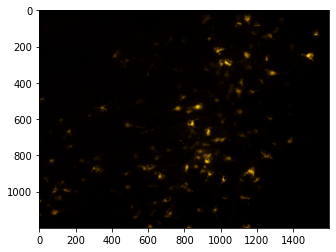

In [11]:
plt.imshow(x[3].permute(1,2,0))

In [18]:
model.eval()
with torch.no_grad():
    if vae:
        mu, log_var, (mu_p, sigma_p) = model(x.to(device))
        heatmap = mu_p
    else:
        heatmap = model(x.to(device))
    if ae:
        ae_image=heatmap

In [104]:
#y = y.permute(0, 3, 1, 2)
#x = x.permute(0, 3, 1, 2)

In [22]:
sigma_p.size()

torch.Size([4, 1, 1200, 1600])

In [43]:
y.size()

torch.Size([4, 3, 1200, 1600])

In [44]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

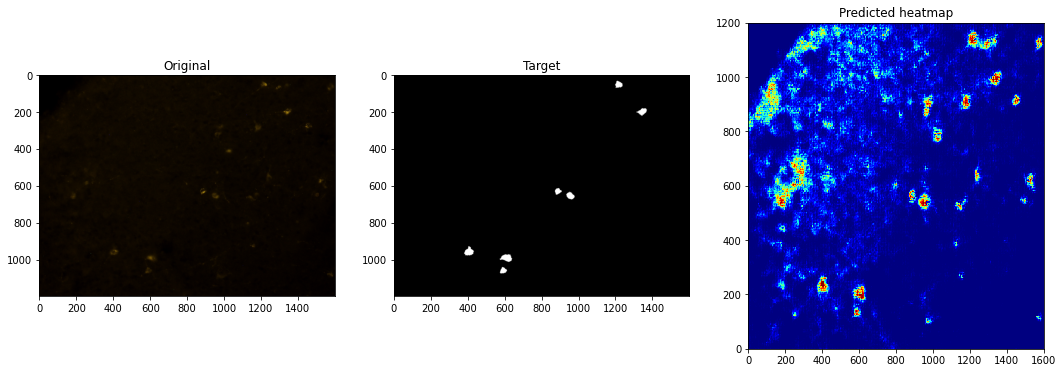

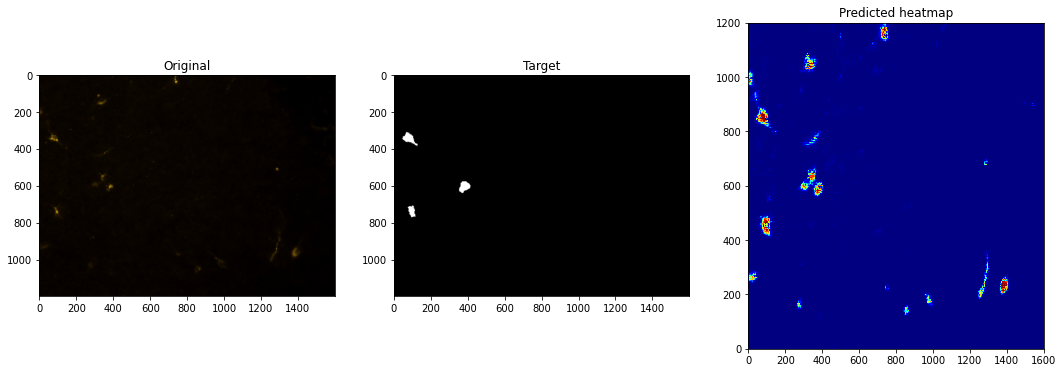

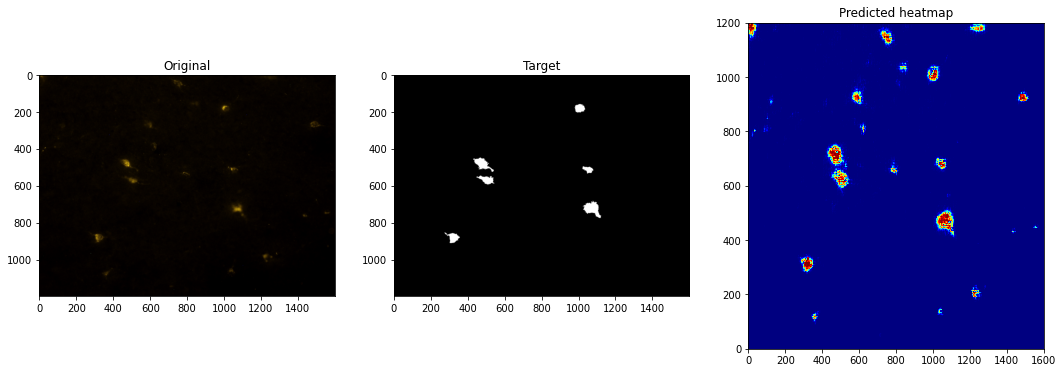

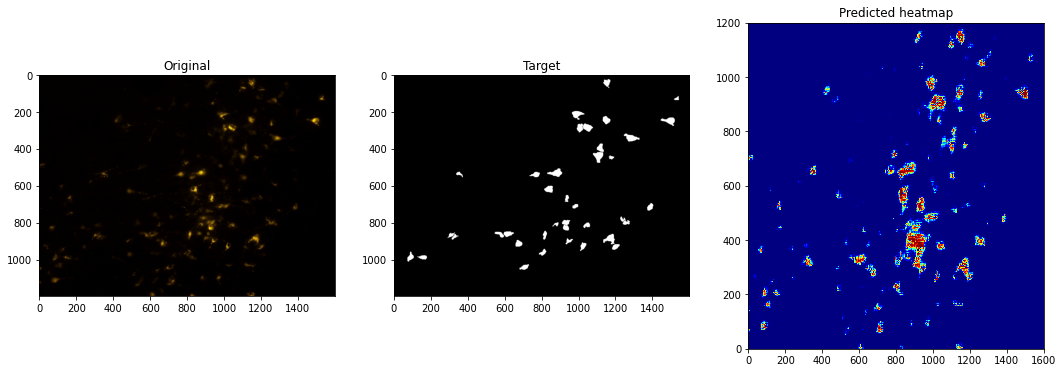

In [45]:
for i in range(heatmap.size()[0]):
    
#     print(test_ids[i+start])
    original = x[i].permute(1,2,0)
    target = y[i].permute(1,2,0)
    heat_map = heatmap[i]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    
    if ae:
        im = axes[0].imshow(original)
        axes[0].set_title('Original')

        im = axes[1].imshow((target), cmap='gray')
        axes[1].set_title('Target')
        
        im = axes[2].imshow((heat_map.permute(1,2,0).cpu().detach()))
        axes[2].set_title('Predicted heatmap') 
        
    else:        
       
        im = axes[0].imshow(original)
        axes[0].set_title('Original')

        im = axes[1].imshow(np.squeeze(target), cmap='gray')
        axes[1].set_title('Target')
    
        im = axes[2].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()), cmap='jet')
        #divider = make_axes_locatable(axes[2])
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #plt.colorbar(im, cax=cax)
        axes[2].set_title('Predicted heatmap') 
